In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from scipy import stats
import seaborn as sns
from functools import reduce
pd.options.mode.chained_assignment = None 
from statistics import mean
from Profile_Generation import *
from plotting import *
import warnings
warnings.simplefilter('ignore', np.RankWarning)
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from openpyxl import load_workbook
import math
from scipy.optimize import OptimizeWarning
warnings.simplefilter("ignore", OptimizeWarning)
import timeit
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import cm
from matplotlib.patches import Patch
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import levene
import sys

No handles with labels found to put in legend.


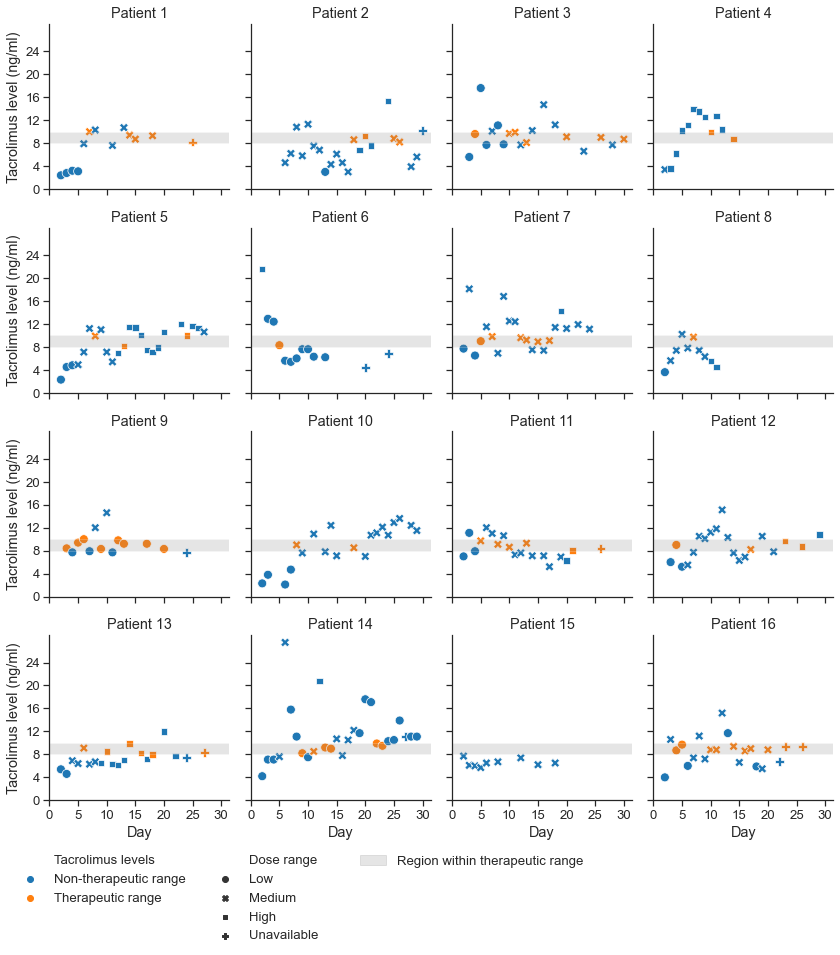

In [2]:
dat = response_vs_day()


In [4]:
df = dat.copy()
df

,Day,response,dose,patient,ideal,body_weight,dose_BW,Tacrolimus levels,Dose range
0,2,2.4,0.5,1,True,9.7,0.051546,Non-therapeutic range,Low
1,3,2.8,1.0,1,True,9.7,0.103093,Non-therapeutic range,Low
2,4,3.2,1.5,1,True,9.7,0.154639,Non-therapeutic range,Low
3,5,3.1,1.5,1,True,9.7,0.154639,Non-therapeutic range,Low
4,6,7.9,3.0,1,True,9.7,0.309278,Non-therapeutic range,Medium
...,...,...,...,...,...,...,...,...,...
448,27,NaN,NaN,16,False,18.45,NaN,Non-therapeutic range,Unavailable
449,28,NaN,NaN,16,False,18.45,NaN,Non-therapeutic range,Unavailable
450,29,NaN,NaN,16,False,18.45,NaN,Non-therapeutic range,Unavailable
451,30,NaN,NaN,16,False,18.45,NaN,Non-therapeutic range,Unavailable


In [2]:
%%time
# ~5mins

# Execute CURATE without pop tau
execute_CURATE(pop_tau_string='')

Patient #117 has insufficient/<3 predictions (1 predictions) (for linear)!
Patient #117 has insufficient/<3 predictions (0 predictions) (for quadratic)!
Patient #121 has insufficient unique dose-response pairs for calibration (for quad)!
Patient #126 has insufficient unique dose-response pairs for calibration (for quad)!
Patient #130 has insufficient/<3 predictions (2 predictions) (for linear)!
Patient #130 has insufficient/<3 predictions (1 predictions) (for quadratic)!
Patient #133 has insufficient/<3 predictions (0 predictions) (for linear)!
Patient #133 has insufficient unique dose-response pairs for calibration (for quad)!
Patients to exclude for linear methods: ['117', '130', '133']
Patients to exclude for quad methods: ['117', '121', '126', '130', '133']
Wall time: 3min 47s


In [ ]:
%%time
# Perform CV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_CV()
execute_CURATE_and_update_pop_tau_results('CV', five_fold_cross_val_results_summary, five_fold_cross_val_results)

# Perform LOOCV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_LOOCV()
execute_CURATE_and_update_pop_tau_results('LOOCV', five_fold_cross_val_results_summary, five_fold_cross_val_results)